# Classical modeling using bayesian inference

In this notebook we will fit some basic time series model to our data. To keep the problem simple, we will initially put our focus on just one time series

In [69]:
import pandas as pd
import numpy as np
from scipy import signal
pd.options.mode.chained_assignment = None

from datetime import timedelta

import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcdefaults()
plt.style.use('fivethirtyeight')
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams.update({'font.size': 16})

import pystan
import arviz as az

## AR(p)

The process is written as

$$
y_t = \sum_{i=1}^p \psi_i y_{t-i} + \epsilon, \quad \epsilon \sim \mathcal{N}(0, \sigma^2)
$$

Here our parameter vector is maden by $\underline \theta = [\psi_1, \ldots, \psi_p, \sigma^2]$. We assume the following conjugate prior

$$
\begin{align*}
\underline \psi &\sim \mathcal{N}_p(\underline \mu_0, \sigma^2 C_0) \\
\sigma^2 &\sim inv\Gamma\Biggl(\frac{n_0}{2}, \frac{n_0 \sigma_0^2}{2} \Biggr)
\end{align*}
$$

In [2]:
# load data as produced by DataCollection
fullData = pd.read_csv("../data/tsData.csv")
fullData["created_at"] = pd.to_datetime(fullData["created_at"])
fullData.set_index("created_at", inplace=True)

# set pot, and period of time where consider data
interestingPot = 1091
startDate      = "2020-09-01"
endDate        = fullData.index.max()


data = fullData.loc[fullData["pot_id"]==interestingPot][startDate:endDate]

# drop useless features in this analysis
data.drop(["latitude", "longitude", "weekend"], axis = 1, inplace = True)
data = data.dropna()
data.head()

,pot_id,pm1SPS,pm2p5SPS,pm4SPS,pm10SPS,temperature_sht,humidity_sht,wind,rain
created_at,,,,,,,,,
2020-09-01 00:00:00,1091,3.2225,3.5,4.6825,4.7975,12.6550,68.01,1.5,0.0
2020-09-01 01:00:00,1091,4.4800,5.0,6.0300,6.1500,11.9200,70.00,1.3,0.0
2020-09-01 02:00:00,1091,8.1200,8.0,11.3200,11.5600,10.6200,70.00,0.8,0.0
2020-09-01 03:00:00,1091,6.4100,6.0,7.5300,7.6000,10.2800,70.00,0.5,0.0
2020-09-01 04:00:00,1091,6.5600,6.0,7.9150,8.0000,10.0275,70.00,0.1,0.0


In [3]:
# fit the model and run MCMC
model_code = '''
    data{
        int<lower=0> N;
        real y[N];
    }
    parameters {
        real phi1;
        real phi2;
        real<lower=0> sigma;
    } 
    model {
        sigma ~ inv_gamma(2,100);
        phi1  ~ normal(0,1);
        phi2  ~ normal(0,1);
        
        for (n in 3:N){
            y[n] ~ normal(phi1 * y[n-1] + phi2 * y[n-2] , sigma);
        }
    }
'''

model = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1bb38617fb6dadf06192c8c8ac532c26 NOW.


In [4]:
MCMCdata = {'N': len(data["pm2p5SPS"].index),
            'y': data["pm2p5SPS"].values}

y = model.sampling(data=MCMCdata, iter = 10000).extract()

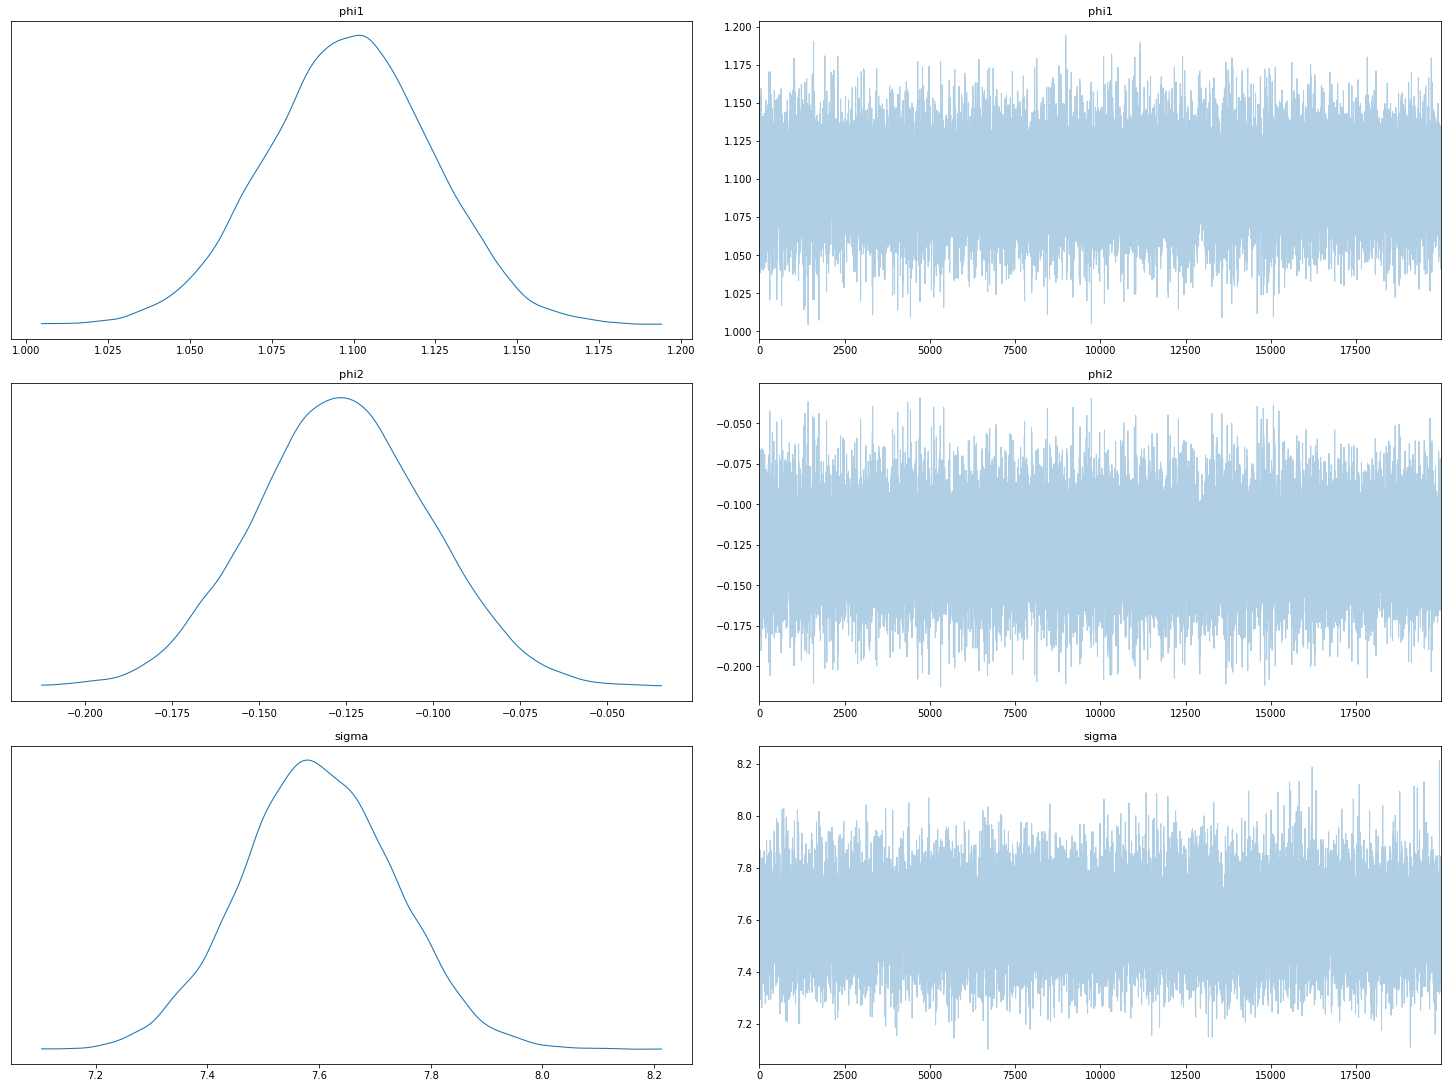

In [5]:
# plot the results
plotDict = {k : y[k] for k in ['phi1', 'phi2', 'sigma']}
az.plot_trace(plotDict)
plt.gcf().set_size_inches(20, 15)
plt.show()

In [71]:
from numpy.random import normal
import math

# try a forecast for the next day...
startingDay = data.index.max() - timedelta(days = 1)

# create pandas dataframe for MCMC sample
MCMCsample = pd.DataFrame.from_dict(y)
MCMCsample.drop("lp__", inplace = True, axis = 1)

# create a pandas dataframe where to store columnwise the distribution of the response for each hour
predictionResult = pd.DataFrame(columns = range(1,24))

# function computing simulated value from AR(2) process
def pred(row):
    return normal(row['phi1']*row['t-1'] + row['phi2']*row['t-2'], math.sqrt(row['sigma']))

startData = [data.loc[startingDay]["pm2p5SPS"], data.loc[startingDay - timedelta(hours = 1)]["pm2p5SPS"]]

# add lagged values
MCMCsample['t-1'] = data.loc[startingDay]["pm2p5SPS"]
MCMCsample['t-2'] = data.loc[startingDay - timedelta(hours = 1)]["pm2p5SPS"]

for i in range(1,24):
    hourPredDistrib = pd.DataFrame()   
    res = MCMCsample.apply(lambda row: pred(row),axis=1)
    predictionResult[i] = res
    MCMCsample['t-2'] = MCMCsample['t-1']
    MCMCsample['t-1'] = res

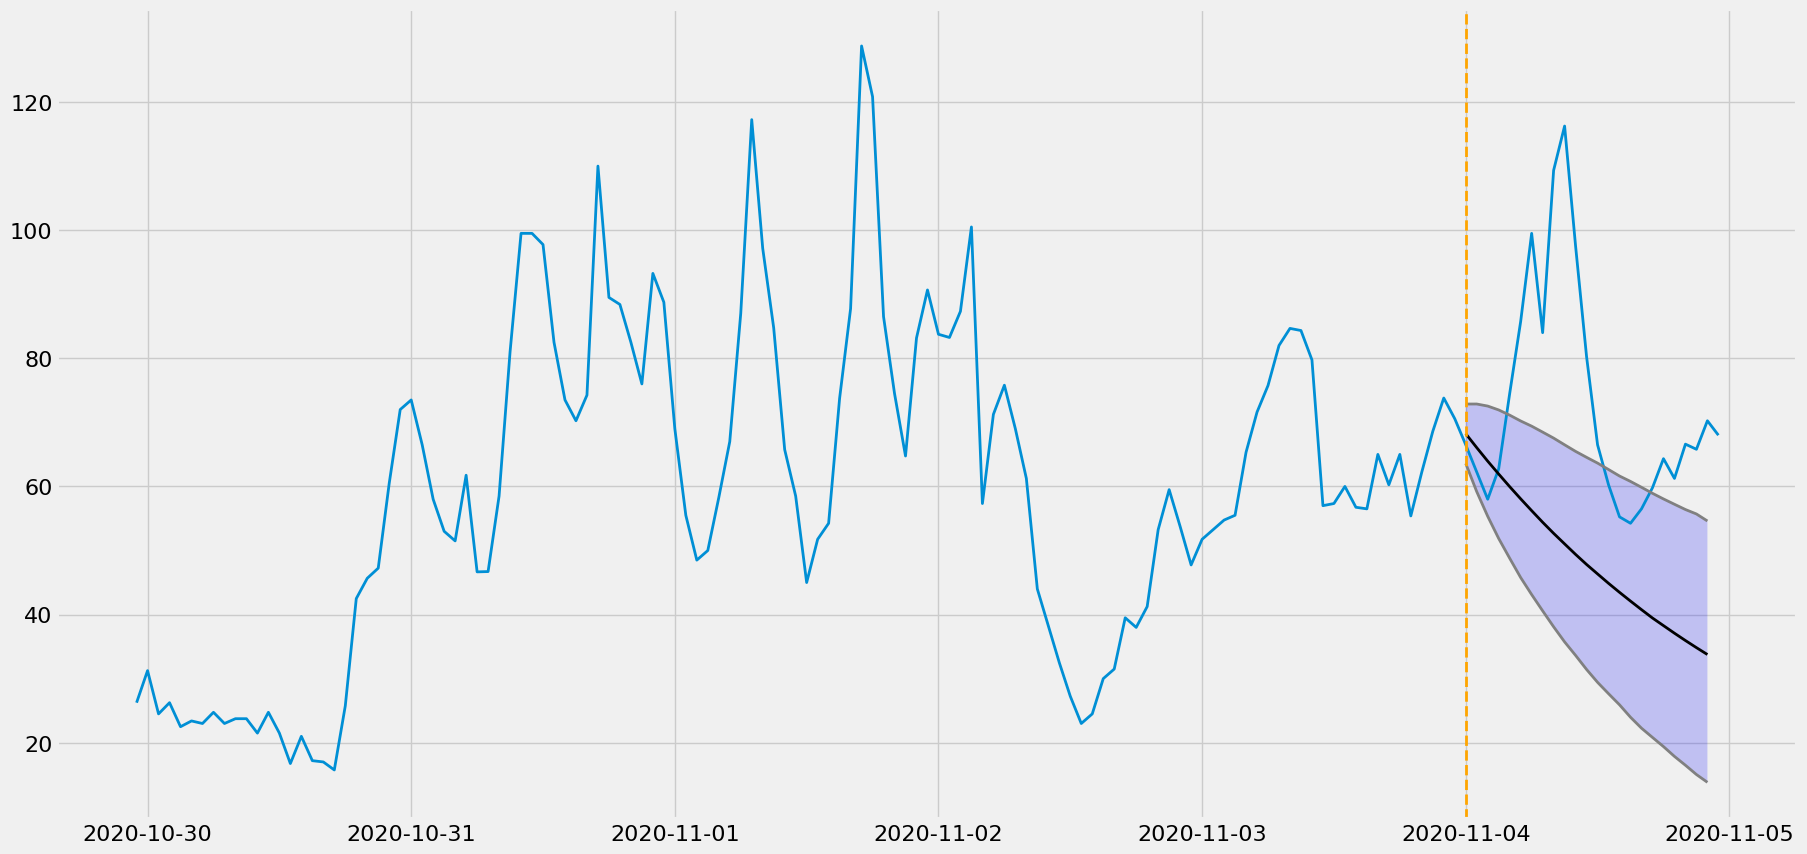

In [70]:
# plot forecast

result     = predictionResult.apply(lambda col: np.mean(col))           # mean
quantile5  = predictionResult.apply(lambda col: np.quantile(col, 0.05)) # 5% quantile
quantile95 = predictionResult.apply(lambda col: np.quantile(col, 0.95)) # 95% quantile
dateIndex = [startingDay + timedelta(hours = i) for i in range(1,len(result)+1)]

# create dataset for plotting
resultDF = pd.DataFrame({"mean": result,
                         "quantile5" : quantile5,
                         "quantile95" : quantile95,
                         "date": dateIndex})
resultDF["date"] = pd.to_datetime(resultDF["date"])
resultDF.set_index("date", inplace=True)

# plot
plt.gcf().set_size_inches(20, 10)
plt.plot(data[startingDay - timedelta(days=5): startingDay + timedelta(days=1)]["pm2p5SPS"])
plt.plot(resultDF["mean"], color="black", linewidth=2)
plt.plot(resultDF["quantile5"], color="grey", linewidth=2)
plt.plot(resultDF["quantile95"], color="grey", linewidth=2)
plt.axvline(x=dateIndex[0], color="orange", linestyle='dashed')
plt.fill_between(resultDF.index, resultDF["quantile5"], resultDF["quantile95"], facecolor='blue', alpha=.2)
plt.show()